<a href="https://colab.research.google.com/github/iMan0405/Portfolio_DT_vs_AI/blob/main/Sentiment_Analysis_for_Social_Media.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis modeli (Ijtimoiy tarmoq uchun)

### ushbu modelda twitter dataseti dan foydalanamiz va izohlarda qoldirilgan hissiyotlarni tahlil qilamiz:

Dataset haqida ma'lumot:
**textID** - matnning har bir qismi uchun noyob identifikator;
**text** - izoh matni;
**sentiment** - izohga berilgan hissiyot.

### birinchi navbatda kutubxonalarni yuklab olishimiz lozim

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

### Sentiment datasetini yuklab olamiz

In [3]:
df = pd.read_csv('/content/Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### textID va selected_text ustunlarini o'chirib yuboramiz, shuningdek, yangi o'zgaruvchiga df ni saqlab olamiz

In [4]:
df.drop(['textID', 'selected_text'], axis = 1, inplace = True )
target = 'sentiment'
df.reset_index(drop = True, inplace = True)
original_df = df.copy(deep = True)
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [5]:
print("Ma'lumot to'plamlarining o'lchamlari: ", df.shape)
df.info()

Ma'lumot to'plamlarining o'lchamlari:  (27481, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [6]:
df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


### yuqorida holatda df ni tahlil qildik, va text ustunida 27480 ta, sentiment ustunida 27481 ta ma'lumot bor, demak text ustunida 1 ta null qiymat borligini bildiradi, buni bartaraf qilishimiz lozim

In [7]:
df.isnull().sum()

text         1
sentiment    0
dtype: int64

In [8]:
df.dropna(inplace = True)
original_df = df.copy()

### dulikatlarni tekshirib ko'ramiz

In [9]:
df.duplicated().sum()

0

### so'zlarni hisoblaymiz

In [10]:
df['world_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df[['text', 'world_count']].head()

,text,world_count
0,"I`d have responded, if I were going",8
1,Sooo SAD I will miss you here in San Diego!!!,11
2,my boss is bullying me...,5
3,what interview! leave me alone,6
4,"Sons of ****, why couldn`t they put them on t...",15


In [11]:
df['char_count'] = df['text'].str.len()
df[['text', 'char_count']].head()

,text,char_count
0,"I`d have responded, if I were going",36
1,Sooo SAD I will miss you here in San Diego!!!,46
2,my boss is bullying me...,25
3,what interview! leave me alone,31
4,"Sons of ****, why couldn`t they put them on t...",75


In [12]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words) / len(words))
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))
df[['text', 'avg_word']].head()

,text,avg_word
0,"I`d have responded, if I were going",4.142857
1,Sooo SAD I will miss you here in San Diego!!!,3.600000
2,my boss is bullying me...,4.200000
3,what interview! leave me alone,5.200000
4,"Sons of ****, why couldn`t they put them on t...",4.357143


In [13]:
nltk.download('stopwords')
stop = stopwords.words('english')

df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text', 'stopwords']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,stopwords
0,"I`d have responded, if I were going",3
1,Sooo SAD I will miss you here in San Diego!!!,4
2,my boss is bullying me...,2
3,what interview! leave me alone,2
4,"Sons of ****, why couldn`t they put them on t...",7


In [14]:
df['hastags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['text', 'hastags']].head()

,text,hastags
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [15]:
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text', 'numerics']].head()

,text,numerics
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


## Wordcloud

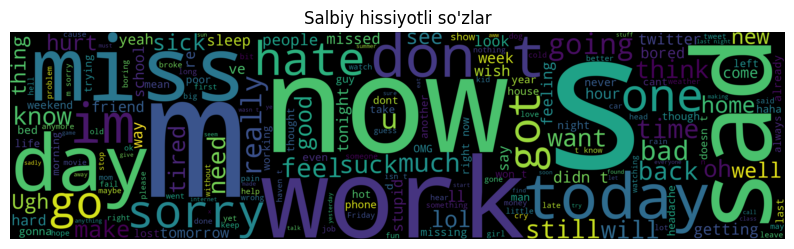

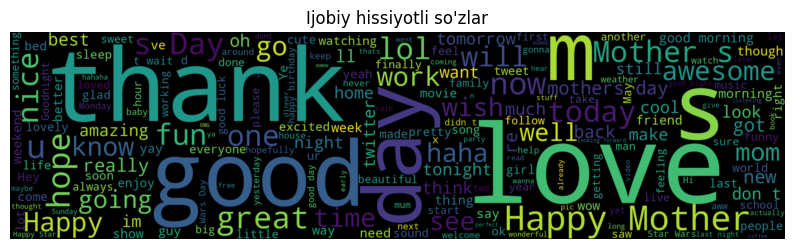

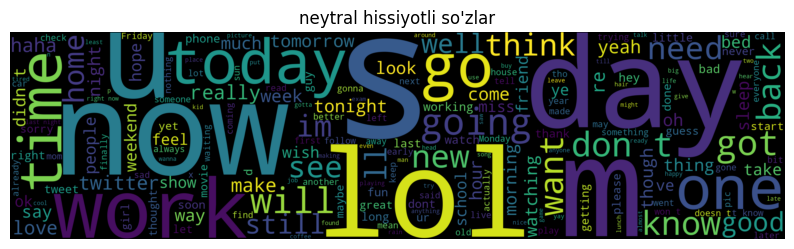

In [16]:
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

def generate_wordcloud(data, title):
  words = " ".join(data['text'])
  cleaned_word = " ".join([word for word in words.split()
                          if 'http' not in word
                           and not word.startswith('@')
                           and word != 'RT'])
  wordcloud = WordCloud(stopwords = STOPWORDS, background_color = 'black', width = 3000, height = 800).generate(cleaned_word)
  plt.figure(figsize = (10, 5))
  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.title(title)
  plt.axis('off')
  plt.show()

generate_wordcloud(negative_df, "Salbiy hissiyotli so'zlar")
generate_wordcloud(positive_df, "Ijobiy hissiyotli so'zlar")
generate_wordcloud(neutral_df, "neytral hissiyotli so'zlar")

### Basic Pre-Processing

In [17]:
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

df['text'].str.replace('[^\w\s]', '')

stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

0                               i`d responded, going
1                         sooo sad miss san diego!!!
2                                boss bullying me...
3                             interview! leave alone
4    sons ****, couldn`t put releases already bought
Name: text, dtype: object

### Common Words Removal

In [18]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:30]
freq

i`m       2173
day       1481
get       1415
good      1325
like      1303
it`s      1174
go        1162
-         1147
got       1069
going     1062
love      1060
happy      914
work       878
don`t      850
u          848
really     841
one        838
im         824
****       796
back       781
see        765
know       757
can`t      746
time       739
new        725
lol        697
want       695
&          675
still      661
think      656
dtype: int64

In [19]:
freq = ["I'm", "-", "****", "&"]
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['text'].head()

0                               i`d responded, going
1                         sooo sad miss san diego!!!
2                                boss bullying me...
3                             interview! leave alone
4    sons ****, couldn`t put releases already bought
Name: text, dtype: object

In [20]:
freq = pd.Series(" ".join(df['text']).split()).value_counts()[-10:]
freq

neaaarr                      1
wer                          1
sigh.....                    1
@_harrykim                   1
#design                      1
http://tinyurl.com/dl2upx    1
resources                    1
pours.                       1
cyalater!!!                  1
((hugs))                     1
dtype: int64

In [21]:
st = PorterStemmer()
df['text'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0                               i`d responded, go
1                      sooo sad miss san diego!!!
2                                boss bulli me...
3                            interview! leav alon
4    son ****, couldn`t put releas alreadi bought
Name: text, dtype: object

                 Hissiyotlar taqsimoti                 


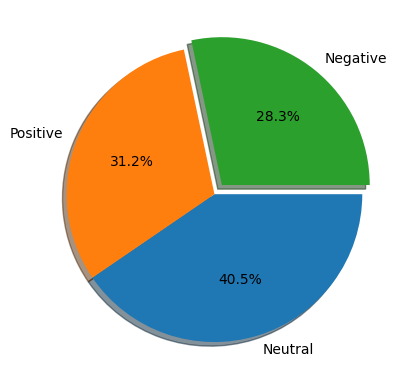

In [22]:
print("Hissiyotlar taqsimoti".center(55))
plt.pie(df[target].value_counts(), labels = ['Neutral','Positive','Negative'], counterclock = False, shadow = True,
        explode = [0, 0, 0.08], autopct = '%1.1f%%', radius = 1, startangle = 0)
plt.show()

### Modelni Prediction qilish jarayoni

In [23]:
X = df['text']
y = df['sentiment']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X).toarray()
vectorizer

TfidfVectorizer()

### qiymatlarni o'zgaruvchilarga saqlab olamiz

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### natijalarni saqlash uchun jadval yaratib olamiz

In [25]:
results_df = pd.DataFrame(np.zeros((2, 5)), columns = ['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
results_df.index = ['Logistic Regression (LR)','Naïve Bayes Classifier (NB)']
results_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


### Klassifikatsiya funksiyasini yozamiz

In [26]:
def Classification_Summary(pred,pred_prob,i):
    results_df.iloc[i]['Accuracy']=round(accuracy_score(y_test, pred),3)*100
    results_df.iloc[i]['Precision']=round(precision_score(y_test, pred, average='weighted'),3)*100
    results_df.iloc[i]['Recall']=round(recall_score(y_test, pred, average='weighted'),3)*100
    results_df.iloc[i]['F1-score']=round(f1_score(y_test, pred, average='weighted'),3)*100
    results_df.iloc[i]['AUC/ROC score']=round(roc_auc_score(y_test, pred_prob, multi_class='ovr'),3)*100
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,results_df.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'),3)*100))
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))

    roc_auc_score(y_test, pred_prob, multi_class='ovr')
    plt.show()

### Vizialuzatsiya funksiyasi

In [27]:
def AUC_ROC_plot(y_test, pred):
  ref = [0 for _ in range(len(y_test))]
  ref_auc = roc_auc_score(y_test, ref)
  lr_auc = roc_auc_score(y_test, pred)

  ns_fpr, ns_tpr = roc_curve(y_test, ref)
  lr_fpr, lr_tpr = roc_curve(y_test, pred)

  plt.plot(ns_fpr, ns_tpr, linestyle = '--')
  plt.plot(lr_fpr, lr_tpr, marker = '.', label = f"AUC = {round(roc_auc_score(y_test, pred) * 100, 2)}")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

# Logistics Regression Model

In [28]:
LR_model = LogisticRegression()
LR = LR_model.fit(X_train, y_train)

In [29]:
pred = LR.predict(X_test)
pred_prob = LR.predict_proba(X_test)
Classification_Summary(pred,pred_prob,0)

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 68.5%
F1 Score = 68.4%

 Confusiton Matrix:
 [[ 848  589   86]
 [ 257 1775  243]
 [  51  505 1142]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.56      0.63      1523
     neutral       0.62      0.78      0.69      2275
    positive       0.78      0.67      0.72      1698

    accuracy                           0.69      5496
   macro avg       0.71      0.67      0.68      5496
weighted avg       0.70      0.69      0.68      5496



### Modelni saqlab olish

In [ ]:
import pickle
filename = 'LR_model_SocialMedia.pkl'
with open(filename, 'wb') as file:
    pickle.dump(LR, file)

### Naive Bayes Classfier

In [ ]:
NB_model = BernoulliNB()
NB = NB_model.fit(X_train, y_train)
pred = NB.predict(X_test)
pred_prob = NB.predict_proba(X_test)
Classification_Summary(pred, pred_prob, 1)

In [30]:
display("Modellarni solishtirish", results_df)

'Modellarni solishtirish'

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),68.5,69.9,68.5,68.4,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


# Yuqoridagi modellarni solishtirish jadvalida faqat Logistic Regression modeli natijasi mavjud, Naive Bayes Classifier modelida train qilish uchun katta hajmli OZU kerak bo'lar ekan, bepul ajratilgan OZU hajmi ushbu modelni training qilishga kuchi yetmadi.